In [1]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

sample_info = pd.read_csv('MOB_sample_info.csv', index_col=0)

df = pd.read_csv('data/Rep11_MOB_0.csv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

import NaiveDE

dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

Populating the interactive namespace from numpy and matplotlib


In [2]:
res.shape

(260, 14859)

In [5]:
results = pd.read_csv('MOB_final_results.csv', index_col=0)

results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)

sres = results.query('qval < 0.05 & g != "log_total_count"').copy()

X = sample_info[['x', 'y']].values
Y = res[sres['g']].values.T

In [6]:
import GPy
import GPclust

In [115]:
np.random.seed(1)


m = GPclust.MOHGP(X=X,
                  Y=Y,
                  kernF=GPy.kern.RBF(2) + GPy.kern.Bias(2),
                  kernY=GPy.kern.RBF(1) + GPy.kern.White(1),
                  K=5,
                  prior_Z='DP')

m.hyperparam_opt_args['messages'] = False

# m.optimize(step_length=0.1, verbose=False)

In [116]:
m.optimize(step_length=0.1, verbose=False, maxiter=2000)

In [117]:
m

MOHGP.,value,constraints,priors
sum.rbf.variance,0.0762792947372,+ve,
sum.rbf.lengthscale,0.739322494657,+ve,
sum.bias.variance,21.025022098,+ve,
sum_1.rbf.variance,5.16602297981,+ve,
sum_1.rbf.lengthscale,294.674277121,+ve,
sum_1.white.variance,0.139975033996,+ve,


In [118]:
m.phi_hat

array([ 11.00000003,   8.0001406 ,  19.00000004,  14.99999997,  13.99985936])

In [119]:
sres['cluster'] = m.phi_.argmax(1)
Cs = m.predict_components(X)

In [120]:
K_hat = len(sres.cluster.unique())
K_hat

5

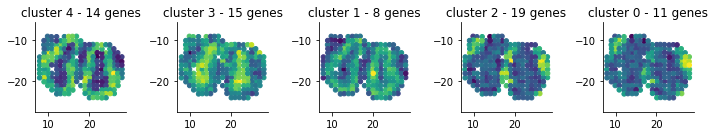

In [121]:
figsize(10, 2)
for i, Ci in enumerate(sres.cluster.unique()):
    C = Cs[0][Ci]
    plt.subplot(1, K_hat, i + 1)
    plt.scatter(X[:,0], -X[:,1], c=C, s=20)
    plt.axis('equal')
    plt.title('cluster {} - {} genes'.format(Ci, sres.query('cluster == @Ci').shape[0] ))
    
plt.tight_layout()

In [122]:
for i in sres.cluster.unique():
    
    print('Cluster {}'.format(i))
    print(', '.join(sres.query('cluster == @i')['g'].tolist()))

Cluster 4
Rab3b, Slc17a7, Slc6a11, Trnp1, Gabra1, Igfbp2, Cck, Cpe, Aqp4, Doc2g, Slc1a2, Cdhr1, Sparcl1, Nrsn1
Cluster 3
Necab2, Pcp4, Rbfox3, Penk, Arhgap33, Nrgn, Prokr2, Kcnh3, Camk2b, Baiap2, Gpsm1, Pbx1, Tubb2b, Ncdn, Mbp
Cluster 1
Tspan7, Cdr1, 4933405L10Rik, Taf7l, Gna14, Olfr635, Cplx1, Atp1b1
Cluster 2
Pmepa1, Frzb, Fabp7, Apod, S100a5, Vtn, Lpar1, Omp, Kif5b, Sorbs1, Nr2f2, Scd1, Mcf2l, Kctd12, Foxd3, Gng13, Sash1, Igfbp5, Ptn
Cluster 0
Apc, Marcks, Trak2, Igf1, Unc13c, Ccnd1, Sepp1, Apoe, Glul, Ptgds, Sfrp5
